# AABC cumulative recruitment stats and visuals


In [676]:
# check out  ~/cron/aabc_recruits.sh
#

In [677]:
#load some libraries
import pandas as pd
import seaborn as sns
from ccf.box import LifespanBox
import yaml
from functions import *
from config import *
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import warnings
from itables import show
import itables.options as opt
warnings.filterwarnings('ignore')

In [678]:
opt.maxBytes = "128KB"

In [679]:
print(date.today().strftime("%m/%d/%Y"))

10/30/2024


In [680]:
#load HCA inventory 
config = LoadSettings()
secret=pd.read_csv(config['config_files']['secrets'])
box = LifespanBox(cache="./tmp")
pathp=box.downloadFile(config['hcainventory'])
ids=pd.read_csv(pathp)

In [681]:
## get configuration files
intradb=pd.read_csv(config['config_files']['PCP'])
#aabc_processing=config['aabc_processing']

In [682]:
DNR = ["HCA7787304_V1", "HCA6276071_V1", "HCA6229365_V1", "HCA9191078_V1", "HCA6863086_V1"]
#These guys accidentally recruited as V2
v2oops=['HCA6686191','HCA7296183']

In [683]:
aabcdictionary='AABC_REDCap_DataDictionary_2023-05-15.csv'                 # aabc REDCap data dictionary...necessary for automating variables at appropriate events - put in tmpdir
#AABCdict=pd.read_csv(outp+aabcdictionary,low_memory=False)
E=pd.read_csv(box.downloadFile(config['encyclopedia']),low_memory=False,encoding='ISO-8859-1')
SSAGAvars=list(E.loc[E['Form / Instrument'].str.upper().str.contains('SSAGA'),'Variable / Field Name'])

In [684]:
hcaids=ids.subject.drop_duplicates()
#for later use in getting the last visit for each participant in HCA so that you can later make sure that person is starting subsequent visit and not accidentally enrolled in the wrong arm
hca_lastvisits=ids[['subject','redcap_event']].loc[ids.redcap_event.isin(['V1','V2'])].sort_values('redcap_event').drop_duplicates(subset='subject',keep='last')

In [685]:
#load AABC report
aabcarms = redjson(tok=secret.loc[secret.source=='aabcarms','api_key'].reset_index().drop(columns='index').api_key[0])
hcpa = redjson(tok=secret.loc[secret.source=='hcpa','api_key'].reset_index().drop(columns='index').api_key[0])
#just a report
aabcreport = redreport(tok=secret.loc[secret.source=='aabcarms','api_key'].reset_index().drop(columns='index').api_key[0],reportid='51031')


In [686]:

#download the inventory report from AABC for comparison
aabcinvent=getframe(struct=aabcreport,api_url=config['Redcap']['api_url10']).drop(columns='dob')


HTTP Status: 200


## CODE RED!

In [687]:
#find subjectts who have completed a visit and are not DNR - save for later
reds=aabcinvent.loc[aabcinvent.register_visit_complete =='2'][['study_id']]
inperson=list(reds.study_id.unique())
reds2=aabcinvent.loc[(aabcinvent.study_id.isin(inperson)) & (~(aabcinvent.subject_id =='')) & (~(aabcinvent.subject_id.isin(DNR)))]
inpersonHCAid=list(reds2.subject_id.unique())

In [688]:
#trying to set study_id from config file, but have been sloppy...there are instances where the actual subject_id has been coded below
study_id=config['Redcap']['datasources']['aabcarms']['redcapidvar']

#slim selects just the registration event (V0) because thats where the ids and legacy information is kept.
slim=aabcinvent[['study_id','redcap_event_name',study_id,'legacy_yn','site','v0_date']].loc[(aabcinvent.redcap_event_name.str.contains('register'))]

#compare aabc ids against hcaids and whether legacy information is properly accounted for (e.g. legacy variable flags and actual event in which participannt has been enrolled.
fortest=pd.merge(hcaids,slim,left_on='subject',right_on=study_id,how="outer",indicator=True)
#fortest._merge.value_counts()
legacyarms=['register_arm_1','register_arm_2','register_arm_3','register_arm_4','register_arm_5','register_arm_6','register_arm_7','register_arm_8']

In [689]:
# First batch of flags: Look for legacy IDs that don't actually exist in HCA
ft=fortest.loc[(fortest._merge=='right_only') & ((fortest.legacy_yn=='1')|(fortest.redcap_event_name.isin(legacyarms)))]
#remove the TEST subjects -- probably better to do this first, but sigh.
ft=ft.loc[~((ft[study_id]=='')|(ft[study_id].str.upper().str.contains('TEST')))]
qlist1=pd.DataFrame()
if not ft.empty:
    ft['reason']='Subject found in AABC REDCap Database with legacy indications whose ID was not found in HCP-A list'
    ft['issueCode']='AE1001'
    ft['datatype']='REDCap'
    ft['code']='RED'
    qlist1=ft[['subject_id', 'study_id', 'redcap_event_name', 'site','reason','code','v0_date','datatype']]
    for s in list(ft[study_id].unique()):
        print('CODE RED :',s,': Subject found in AABC REDCap Database with legacy indications whose ID was not found in HCP-A list')

#2nd batch of flags: if legacy v1 and enrolled as if v3 or v4 or legacy v2 and enrolled v4
ft2=fortest.loc[(fortest._merge=='both') & ((fortest.legacy_yn != '1')|(~(fortest.redcap_event_name.isin(legacyarms))))]
qlist2=pd.DataFrame()
if not ft2.empty:
    ft2['reason']='Subject found in AABC REDCap Database with legacy indications whose ID was not found in HCP-A list'
    ft2['code']='RED'
    ft2['issueCode'] = 'AE1001'
    ft2['datatype']='REDCap'
    qlist2 = ft2[['subject_id', 'study_id', 'redcap_event_name', 'site','reason','code','v0_date','datatype']]
    for s2 in list(ft2[study_id].unique()):
        print('CODE RED :',s2,': Subject found in AABC REDCap Database with an ID from HCP-A study but no legacyYN not checked')



CODE RED : delete (HCA9198092 refusal) : Subject found in AABC REDCap Database with legacy indications whose ID was not found in HCP-A list


In [690]:
# Check if subject fail the screen but came in for visit
pass_failed=aabcinvent.loc[(aabcinvent.passedscreen =='2') & (aabcinvent['subject_id'].astype(str).str.strip() != '')][['subject_id', 'study_id', 'redcap_event_name', 'site','v0_date']]
qlist4=pd.DataFrame()
if not pass_failed.empty:
    pass_failed['reason']='subject did not pass screen but came in for imaging - need confirmation'
    pass_failed['code']='RED'
    pass_failed['issueCode'] = 'AE1001'
    pass_failed['datatype']='REDCap'
    qlist4 = pass_failed[['subject_id', 'study_id', 'redcap_event_name', 'site','reason','code','v0_date','datatype']]
    for s4 in list(pass_failed[study_id].unique()):
        print('CODE RED :',s4,': subject did not pass screen but came in for imaging - need confirmation')

In [691]:
#if legacy v1 and enrolled as if v3 or v4 or legacy v2 and enrolled v4
#get last visit
hca_lastvisits["next_visit"]=''
#idvisits rolls out the subject ids to all visits. get subects current visit for comparison with last visit
aabcidvisits=idvisits(aabcinvent,keepsies=['study_id','redcap_event_name','site','subject_id','v0_date','event_date'])
sortaabc=aabcidvisits.sort_values(['study_id','redcap_event_name'])
sortaabcv=sortaabc.loc[~(sortaabc.redcap_event_name.str.contains('register'))]
sortaabcv.drop_duplicates(subset=['study_id'],keep='first')
#print("OOOPSs:",sortaabcv.loc[sortaabcv.subject.isin(v2oops)])
#add 1 to last visit from HCA
#also set up for checking to make sure not initiating same visit
hca_lastvisits.next_visit=hca_lastvisits.redcap_event.str.replace('V','').astype('int') +1
hca_lastvisits["next_visit2"]="V"+hca_lastvisits.next_visit.astype(str)
hca_lastvisits2=hca_lastvisits.drop(columns=['redcap_event','next_visit'])

In [692]:
#check that current visit in AABC is the last visit in HCA + 1
check=pd.merge(hca_lastvisits2,sortaabcv,left_on=['subject','next_visit2'],right_on=['subject','redcap_event'],how='outer',indicator=True)
check=check.loc[check._merge !='left_only']
wrongvisit=check.loc[check._merge=='right_only']
wrongvisit=wrongvisit.loc[~(wrongvisit.redcap_event.isin(['AP']))]#,'v1_inperson_arm_10','v1_inperson_arm_12']))]
wrongvisit=wrongvisit.loc[wrongvisit.next_visit2.isnull()==False]

In [693]:
qlist3=pd.DataFrame()
if not wrongvisit.empty:
    wrongvisit['reason']='Subject found in AABC REDCap Database initiating the wrong visit sequence (e.g. V3 insteady of V2'
    wrongvisit['code']='RED'
    wrongvisit['issueCode'] = 'AE1001'
    wrongvisit['datatype']='REDCap'
    qlist3 = wrongvisit[['subject', 'study_id', 'redcap_event_name', 'site','reason','code','v0_date','event_date','datatype']]
    qlist3=qlist3.rename(columns={'subject':'subject_id'})
    for s3 in list(wrongvisit['subject'].unique()):
        if s3 !='':
            print('CODE RED (if HCA6911778 ignore) :',s3,': Subject found in AABC REDCap Database initiating the wrong visit sequence (e.g. V3 insteady of V2')
            qlist3=qlist3.loc[~(qlist3.subject_id=='HCA6911778')].copy()

In [694]:
#check to make sure they aren't initiating the same visit.
check2=pd.merge(hca_lastvisits[['subject','redcap_event']],sortaabcv,left_on=['subject','redcap_event'],right_on=['subject','redcap_event'],how='inner')
check2=check2.loc[~(check2.subject.isin(v2oops))]
qlist32=pd.DataFrame()
if not check2.empty:
    check2['reason']='Subject found in AABC REDCap Database initiating the wrong visit sequence (e.g. V3 insteady of V2'
    check2['code']='RED'
    check2['issueCode'] = 'AE1001'
    check2['datatype']='REDCap'
    qlist32 = check2[['subject', 'study_id', 'redcap_event_name', 'site','reason','code','v0_date','event_date','datatype']]
    qlist32=qlist32.rename(columns={'subject':'subject_id'})
    for s3 in list(check2['subject'].unique()):
        if s3 !='':
            print('CODE RED (if HCA6911778 ignore) :',s3,': Subject found in AABC REDCap Database initiating the wrong visit sequence (e.g. V3 insteady of V2')
            qlist32=qlist32.loc[~(qlist32.subject_id=='HCA6911778')].copy()

In [695]:
#test subjects that need to be deleted
tests=aabcinvent.loc[(aabcinvent[study_id].str.upper().str.contains('TEST')) | (aabcinvent[study_id].str.upper().str.contains('PRAC')) | (aabcinvent[study_id].str.upper().str.contains('DEMO'))][['study_id',study_id,'redcap_event_name']]
qlist5=pd.DataFrame()
if not tests.empty:
    tests['reason']='HOUSEKEEPING : Please delete test subject.  Use test database when practicing'
    tests['code']='HOUSEKEEPING'
    tests['datatype']='REDCap'
    tests['issueCode'] = 'AE6001'
    qlist5 = tests[['subject_id', 'study_id', 'redcap_event_name', 'site','reason','code','v0_date','event_date','datatype']]
    for s5 in list(tests[study_id].unique()):
        print('HOUSEKEEPING : Please delete test subject:', s5)

## End of CODE RED

In [696]:
### PPPPP
#CLEAN UP OPTION FOR PRODUCING PLOTS BY VISIT instead of SUBJECT


#api metadata
aabcarms = redjson(tok=secret.loc[secret.source=='aabcarms','api_key'].reset_index().drop(columns='index').api_key[0])
hcpa = redjson(tok=secret.loc[secret.source=='hcpa','api_key'].reset_index().drop(columns='index').api_key[0])

#report deets
aabcreport = redreport(tok=secret.loc[secret.source=='aabcarms','api_key'].reset_index().drop(columns='index').api_key[0],reportid='51031')

#download the inventory report from AABC
#aabcinvent=getframe(struct=aabcreport,api_url=config['Redcap']['api_url10']).drop(columns='dob')
print("shape of inventory before filters or merges",aabcinvent.shape)

#roll up variables that only exist in registration so that you can produce stats by visits
aabcinvent=aabcinvent.drop(columns=['subject_id','site','sex','ethnic','racial','croms_income','counterbalance_1st']).merge(aabcinvent.loc[~(aabcinvent.subject_id =='')][['study_id','subject_id','site','sex','ethnic','racial','croms_income','counterbalance_1st']],on='study_id',how='left')

#print("double check shape of inventory before filters:",aabcinvent.shape)
print("number of unique subjects before filters (includes 1 row for a blank):",str(len(aabcinvent.subject_id.unique())))
print("number of unique REDCap IDs:",str(len(aabcinvent.study_id.unique())))


shape of inventory before filters or merges (2577, 304)
number of unique subjects before filters (includes 1 row for a blank): 948
number of unique REDCap IDs: 1262


In [697]:

aabcinvent['todaydate']=date.today()
#BAD formula:
#aabcinvent['dayspassed']=(pd.to_datetime(aabcinvent.todaydate) - pd.to_datetime(aabcinvent.event_date)).dt.days

#GOOD FORMULA:
aabcinvent['dayspassed']=(pd.to_datetime(aabcinvent.event_date)- pd.to_datetime('05/22/2022')).dt.days
aabcinvent=aabcinvent.sort_values('dayspassed')
#print('data shape: ', str(aabcinvent.shape))
print('selecting visits with completed registration (indicates they actually came in)')
#accrued=aabcinvent.loc[(aabcinvent.register_visit_complete=='2') & (aabcinvent.redcap_event_name.str.contains('inperson'))]
accrued = aabcinvent.loc[aabcinvent.redcap_event_name.str.contains('inperson')].drop_duplicates(subset='subject_id', keep='first')
#print('select first in-person visit: ', str(accrued.shape))
accrued = accrued.loc[accrued.register_visit_complete == '2'] 
#print('select visits with completed registration: ', str(accrued.shape))
print('now the shape of the data is:',str(accrued.shape))

#uncomment if you want to get the event counts
#print(accrued.redcap_event_name.value_counts())


selecting visits with completed registration (indicates they actually came in)
now the shape of the data is: (833, 306)


In [698]:
#print("number of unique subjects now:",str(len(accrued.subject_id.unique())))

In [699]:
droplist=['HCA7787304','HCA7142156','HCA6863086','HCA6276071','HCA6229365','HCA9191078']
accruedclean=accrued.loc[~(accrued.subject_id.isin(droplist))]
print('drop any stragglers that failed screening or withdrew')
print(accruedclean.shape)

#select subjects visit before Oct 1
#accruedclean = accruedclean[accruedclean['event_date'] < '2024-10-01']
#print(accruedclean.shape)

forplot=accruedclean.copy()

#use age at visit (age_visit) instead of age at baseline (age).
forplot=forplot.drop(columns=['age']).rename(columns={'age_visit':'age'})
#print(list(forplot.columns))


drop any stragglers that failed screening or withdrew
(828, 306)


In [700]:
forplot['croms_income'] = forplot['croms_income'].apply(clean_croms_income)

In [701]:
#PREPARE DATA FOR CUMULATIVE PLOTS  
S=pd.get_dummies(forplot.sex, prefix='sex')

#forplot['sexsum']=pd.to_numeric(forplot.sex, errors='coerce').cumsum()
forplot['malesum']=pd.to_numeric(S.sex_1, errors='coerce').cumsum()
forplot['femalesum']=pd.to_numeric(S.sex_2, errors='coerce').cumsum()
forplot['Sex']=forplot.sex.replace({'1':'Male','2':'Female'})

S0=pd.get_dummies(forplot.counterbalance_1st, prefix='CB')
forplot['CB3sum']=pd.to_numeric(S0.CB_3, errors='coerce').cumsum()
forplot['CB4sum']=pd.to_numeric(S0.CB_4, errors='coerce').cumsum()
forplot['Counterbalance']=forplot.counterbalance_1st.replace({'3':'CB3','4':'CB4'})

#forplot[['subject_id','dayspassed','malesum','femalesum','Sex']].head(20)

In [702]:
#forplot.redcap_event_name.value_counts()
forplot['Cohort']=''
forplot.loc[(forplot.redcap_event_name.str.contains("arm_1")) | (forplot.redcap_event_name.str.contains("arm_2")) |(forplot.redcap_event_name.str.contains("arm_3")) |(forplot.redcap_event_name.str.contains("arm_4")) ,'Cohort']='Cohort A'
forplot.loc[(forplot.redcap_event_name.str.contains("arm_5")) | (forplot.redcap_event_name.str.contains("arm_6")) |(forplot.redcap_event_name.str.contains("arm_7")) |(forplot.redcap_event_name.str.contains("arm_8")) ,'Cohort']='Cohort B'
forplot.loc[(forplot.redcap_event_name.str.contains("arm_9")) | (forplot.redcap_event_name.str.contains("arm_10")) |(forplot.redcap_event_name.str.contains("arm_11")) |(forplot.redcap_event_name.str.contains("arm_12")) ,'Cohort']='Cohort C'
#forplot.Cohort

In [703]:
#1, Native American/Alaskan Native | 2, Asian | 3, Black or African American | 4, Native Hawaiian or Other Pacific Is | 5, White | 6, More than one race | 99, Unknown or Not reported
S2=pd.get_dummies(forplot.racial, prefix='race')
#print(S2.head())
forplot['whitesum']=pd.to_numeric(S2.race_5, errors='coerce').cumsum()
#forplot['natpacsum']=pd.to_numeric(S2.race_4, errors='coerce').cumsum()
forplot['blacksum']=pd.to_numeric(S2.race_3, errors='coerce').cumsum()
forplot['asiansum']=pd.to_numeric(S2.race_2, errors='coerce').cumsum()
forplot['natamersum']=pd.to_numeric(S2.race_1, errors='coerce').cumsum()
forplot['moret1sum']=pd.to_numeric(S2.race_6, errors='coerce').cumsum()
forplot['nasum']=pd.to_numeric(S2.race_99, errors='coerce').cumsum()
forplot['Race']=forplot.racial.replace({'1':'Nat Amer/Alaskan','2':'Asian','3':'Black','4':'Nat Hawaiian/PI','5':'White','6':'More than one','99':'Unknown'})

#thnicity
S3=pd.get_dummies(forplot.ethnic, prefix='ethnicity')
forplot['hispanicsum']=pd.to_numeric(S3.ethnicity_1, errors='coerce').cumsum()
forplot['nonhispanicsum']=pd.to_numeric(S3.ethnicity_2, errors='coerce').cumsum()
forplot['unkhispsum']=pd.to_numeric(S3.ethnicity_3, errors='coerce').cumsum()
forplot['Ethnicity']=forplot.ethnic.replace({'1':'Hispanic','2':'Non-Hispanic','3':'Unknown'})

#sites
S4=pd.get_dummies(forplot.site, prefix='site')
forplot['wusum']=pd.to_numeric(S4.site_4, errors='coerce').cumsum()
forplot['umnsum']=pd.to_numeric(S4.site_3, errors='coerce').cumsum()
forplot['mghsum']=pd.to_numeric(S4.site_1, errors='coerce').cumsum()
forplot['uclasum']=pd.to_numeric(S4.site_2, errors='coerce').cumsum()
forplot['Site']=forplot.site.replace({'1':'MGH','2':'UCLA','3':'UMN','4':'WashU'})



In [704]:
#forplot.head(20)

In [705]:
                                       
##ages
bins= [30,40,50,60,70,80,90,125]

forplot['ages']=pd.to_numeric(forplot.age)
forplot['AgeGroup'] = pd.cut(forplot['ages'], bins=bins,right=False)# labels=labels,
S5=pd.get_dummies(forplot.AgeGroup, prefix='age')

forplot['age30sum']=pd.to_numeric(S5['age_[30, 40)'], errors='coerce').cumsum()
forplot['age40sum']=pd.to_numeric(S5['age_[40, 50)'], errors='coerce').cumsum()
forplot['age50sum']=pd.to_numeric(S5['age_[50, 60)'], errors='coerce').cumsum()
forplot['age60sum']=pd.to_numeric(S5['age_[60, 70)'], errors='coerce').cumsum()
forplot['age70sum']=pd.to_numeric(S5['age_[70, 80)'], errors='coerce').cumsum()
forplot['age80sum']=pd.to_numeric(S5['age_[80, 90)'], errors='coerce').cumsum()
forplot['age90sum']=pd.to_numeric(S5['age_[90, 125)'],errors='coerce').cumsum()

In [706]:
bins5= [35,40,45,50,55,60,65,70,75,80,85,90,125]

forplot['AgeGroup5'] = pd.cut(forplot['ages'], bins=bins5,right=False)# labels=labels,
S55=pd.get_dummies(forplot.AgeGroup5, prefix='age5')

forplot['age35sum5']=pd.to_numeric(S55['age5_[35, 40)'], errors='coerce').cumsum()
forplot['age40sum5']=pd.to_numeric(S55['age5_[40, 45)'], errors='coerce').cumsum()
forplot['age45sum5']=pd.to_numeric(S55['age5_[45, 50)'], errors='coerce').cumsum()
forplot['age50sum5']=pd.to_numeric(S55['age5_[50, 55)'], errors='coerce').cumsum()
forplot['age55sum5']=pd.to_numeric(S55['age5_[55, 60)'], errors='coerce').cumsum()
forplot['age60sum5']=pd.to_numeric(S55['age5_[60, 65)'], errors='coerce').cumsum()
forplot['age65sum5']=pd.to_numeric(S55['age5_[65, 70)'], errors='coerce').cumsum()
forplot['age70sum5']=pd.to_numeric(S55['age5_[70, 75)'], errors='coerce').cumsum()
forplot['age75sum5']=pd.to_numeric(S55['age5_[75, 80)'],errors='coerce').cumsum()
forplot['age80sum5']=pd.to_numeric(S55['age5_[80, 85)'],errors='coerce').cumsum()
forplot['age85sum5']=pd.to_numeric(S55['age5_[85, 90)'],errors='coerce').cumsum()
forplot['age90sum5']=pd.to_numeric(S55['age5_[90, 125)'],errors='coerce').cumsum()

#forplot.columns

In [707]:
##ages
bins60= [0,60,125]

forplot['AgeGroup60'] = pd.cut(forplot['ages'], bins=bins60,right=False)# labels=labels,
S60=pd.get_dummies(forplot.AgeGroup60, prefix='age60')

forplot['age1sum60']=pd.to_numeric(S60['age60_[0, 60)'], errors='coerce').cumsum()
forplot['age2sum60']=pd.to_numeric(S60['age60_[60, 125)'],errors='coerce').cumsum()

In [708]:
## croms income
bins_income= [0,20000,50000,100000, np.inf]
labels_income = ['0-20k', '20k-50k', '50k-100k', '100k+']

forplot['income']=pd.to_numeric(forplot.croms_income)
forplot['IncomeGroup'] = pd.cut(forplot['income'], bins=bins_income,labels=labels_income,right=False)# labels=labels,
forplot['IncomeGroup'] = forplot['IncomeGroup'].cat.add_categories('Don\'t know').fillna('Don\'t know')

S6=pd.get_dummies(forplot.IncomeGroup, prefix='income')


In [709]:
## education level
bins_edu = [0, 13, 15, 77, np.inf]
labels_edu = ['Below Highschool', 'Highschool or GED', 'Above Highschool or GED', 'Refused or do not know']

forplot['moca_edu']=pd.to_numeric(forplot.moca_edu)
forplot['EduGroup'] = pd.cut(forplot['moca_edu'], bins=bins_edu,labels=labels_edu,right=False)# labels=labels,
forplot['EduGroup'] = forplot['EduGroup'].cat.add_categories('Don\'t know').fillna('Don\'t know')
S6=pd.get_dummies(forplot.EduGroup, prefix='moca_edu')

## ALL participants, by cohort

In [710]:
#Cohort x Age
pd.crosstab(forplot.Cohort,forplot.AgeGroup5,margins=True)#.plot.bar(rot=45,title='AABC')

AgeGroup5,"[35, 40)","[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 90)","[90, 125)",All
Cohort,,,,,,,,,,,,,
Cohort A,0,22,49,29,55,33,40,32,33,44,40,34,411
Cohort B,0,20,23,25,31,44,30,35,28,29,20,18,303
Cohort C,7,12,9,6,7,11,23,20,9,4,6,0,114
All,7,54,81,60,93,88,93,87,70,77,66,52,828


In [711]:
## Cohort x sex
pd.crosstab(forplot.Cohort,forplot.Sex,margins=True)#.plot.bar(rot=45,title='AABC')

Sex,Female,Male,All
Cohort,,,
Cohort A,222,189,411
Cohort B,186,117,303
Cohort C,68,45,113
All,476,351,827


In [712]:
## Cohort x race
pd.crosstab(forplot.Cohort,forplot.Race,margins=True)#.plot.bar(rot=45,title='AABC')

Race,Asian,Black,More than one,Nat Amer/Alaskan,Nat Hawaiian/PI,Unknown,White,All
Cohort,,,,,,,,
Cohort A,22,57,12,3,1,8,308,411
Cohort B,28,34,9,2,0,7,223,303
Cohort C,3,79,2,0,0,0,29,113
All,53,170,23,5,1,15,560,827


In [713]:
## Cohort x ethnicity
pd.crosstab(forplot.Cohort,forplot.Ethnicity,margins=True)#.plot.bar(rot=45,title='AABC')

Ethnicity,Hispanic,Non-Hispanic,Unknown,All
Cohort,,,,
Cohort A,49,361,1,411
Cohort B,28,271,4,303
Cohort C,1,112,0,113
All,78,744,5,827


In [714]:
#Cohort x Income
pd.crosstab(forplot.Cohort,forplot.IncomeGroup,margins=True)#.plot.bar(rot=45,title='AABC')

IncomeGroup,0-20k,20k-50k,50k-100k,100k+,Don't know,All
Cohort,,,,,,
Cohort A,14,80,147,133,37,411
Cohort B,13,41,104,120,25,303
Cohort C,7,31,50,17,9,114
All,34,152,301,270,71,828


In [715]:
#Cohort x Education
pd.crosstab(forplot.Cohort,forplot.EduGroup,margins=True)#.plot.bar(rot=45,title='AABC')

EduGroup,Below Highschool,Highschool or GED,Above Highschool or GED,Don't know,All
Cohort,,,,,
Cohort A,5,29,375,2,411
Cohort B,6,19,277,1,303
Cohort C,6,12,96,0,114
All,17,60,748,3,828


### AABC Female participants, by age and cohort 

In [716]:
#make a table by cohort, 5-year age
#FeMALES
females=forplot.loc[forplot.Sex=='Female'].copy()
pd.crosstab(females.Cohort,females.AgeGroup5,margins=True)#.plot.bar(rot=45,title='AABC')

AgeGroup5,"[35, 40)","[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 90)","[90, 125)",All
Cohort,,,,,,,,,,,,,
Cohort A,0,11,32,15,34,20,15,15,16,22,23,19,222
Cohort B,0,12,15,17,18,33,24,18,16,15,9,9,186
Cohort C,4,6,5,4,5,7,15,12,5,1,4,0,68
All,4,29,52,36,57,60,54,45,37,38,36,28,476


### AABC Male participants, by age and cohort 

In [717]:
#make a table by cohort, 5-year age
males=forplot.loc[forplot.Sex=='Male'].copy()
pd.crosstab(males.Cohort,males.AgeGroup5,margins=True)#.plot.bar(rot=45,title='AABC')

AgeGroup5,"[35, 40)","[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 90)","[90, 125)",All
Cohort,,,,,,,,,,,,,
Cohort A,0,11,17,14,21,13,25,17,17,22,17,15,189
Cohort B,0,8,8,8,13,11,6,17,12,14,11,9,117
Cohort C,3,6,4,2,2,4,7,8,4,3,2,0,45
All,3,25,29,24,36,28,38,42,33,39,30,24,351


### AABC Female participants, by race and cohort

In [718]:
#make a table by cohort, race
#FeMALES
females=forplot.loc[forplot.Sex=='Female'].copy()
pd.crosstab(females.Cohort,females.Race,margins=True)#.plot.bar(rot=45,title='AABC')

Race,Asian,Black,More than one,Nat Amer/Alaskan,Unknown,White,All
Cohort,,,,,,,
Cohort A,12,38,4,1,4,163,222
Cohort B,12,28,8,1,5,132,186
Cohort C,2,51,0,0,0,15,68
All,26,117,12,2,9,310,476


### AABC Male participants, by race and cohort 

In [719]:
#make a table by cohort, race
#FeMALES
males=forplot.loc[forplot.Sex=='Male'].copy()
pd.crosstab(males.Cohort,males.Race,margins=True)#.plot.bar(rot=45,title='AABC')

Race,Asian,Black,More than one,Nat Amer/Alaskan,Nat Hawaiian/PI,Unknown,White,All
Cohort,,,,,,,,
Cohort A,10,19,8,2,1,4,145,189
Cohort B,16,6,1,1,0,2,91,117
Cohort C,1,28,2,0,0,0,14,45
All,27,53,11,3,1,6,250,351


### AABC Female participants, by ethnicity and cohort

In [720]:
#make a table by cohort, ethnicity
#FeMALES
females=forplot.loc[forplot.Sex=='Female'].copy()
pd.crosstab(females.Cohort,females.Ethnicity,margins=True)#.plot.bar(rot=45,title='AABC')

Ethnicity,Hispanic,Non-Hispanic,Unknown,All
Cohort,,,,
Cohort A,23,198,1,222
Cohort B,22,162,2,186
Cohort C,0,68,0,68
All,45,428,3,476


### AABC Male participants, by ethnicity and cohort

In [721]:
#make a table by cohort, ethnicity
#FeMALES
males=forplot.loc[forplot.Sex=='Male'].copy()
pd.crosstab(males.Cohort,males.Ethnicity,margins=True)#.plot.bar(rot=45,title='AABC')

Ethnicity,Hispanic,Non-Hispanic,Unknown,All
Cohort,,,,
Cohort A,26,163,0,189
Cohort B,6,109,2,117
Cohort C,1,44,0,45
All,33,316,2,351


### Sex stats, by income and education

In [722]:
#make a table by sex, income and education level
pd.crosstab([forplot['Sex']], [forplot['IncomeGroup'], forplot['EduGroup']], margins=True)

IncomeGroup            0-20k                                            \
EduGroup    Below Highschool Highschool or GED Above Highschool or GED   
Sex                                                                      
Female                     4                 3                      16   
Male                       1                 3                       6   
All                        5                 6                      22   

IncomeGroup                     20k-50k                    \
EduGroup    Don't know Below Highschool Highschool or GED   
Sex                                                         
Female               1                2                14   
Male                 0                2                11   
All                  1                4                25   

IncomeGroup                                 50k-100k                    \
EduGroup    Above Highschool or GED Below Highschool Highschool or GED   
Sex                                                                      
Female                           82                5                13   
Male                             41                3                 5   
All                             123                8                18   

IncomeGroup                                                100k+  \
EduGroup    Above Highschool or GED Don't know Highschool or GED   
Sex                                                                
Female                          169          1                 3   
Male                            105          0                 0   
All                             274          1                 3   

IncomeGroup                                           Don't know  \
EduGroup    Above Highschool or GED Don't know Highschool or GED   
Sex                                                                
Female                          116          0                 6   
Male                            150          1                 2   
All                             266          1                 8   

IncomeGroup                          All  
EduGroup    Above Highschool or GED       
Sex                                       
Female                           41  476  
Male                             21  351  
All                              62  827

### Race stats, by income and education

In [723]:
#make a table by race, income and education level
pd.crosstab([forplot['Race']], [forplot['IncomeGroup'], forplot['EduGroup']], margins=True)

IncomeGroup                 0-20k                                            \
EduGroup         Below Highschool Highschool or GED Above Highschool or GED   
Race                                                                          
Asian                           0                 0                       2   
Black                           2                 4                      10   
More than one                   0                 0                       0   
Nat Amer/Alaskan                0                 0                       0   
Nat Hawaiian/PI                 0                 0                       0   
Unknown                         1                 0                       1   
White                           2                 2                       9   
All                             5                 6                      22   

IncomeGroup                          20k-50k                    \
EduGroup         Don't know Below Highschool Highschool or GED   
Race                                                             
Asian                     0                0                 0   
Black                     0                2                12   
More than one             0                1                 0   
Nat Amer/Alaskan          0                0                 0   
Nat Hawaiian/PI           0                0                 0   
Unknown                   0                0                 0   
White                     1                1                13   
All                       1                4                25   

IncomeGroup                                      50k-100k                    \
EduGroup         Above Highschool or GED Below Highschool Highschool or GED   
Race                                                                          
Asian                                  3                0                 0   
Black                                 36                2                 4   
More than one                          4                0                 2   
Nat Amer/Alaskan                       1                0                 0   
Nat Hawaiian/PI                        0                0                 0   
Unknown                                1                3                 3   
White                                 78                3                 9   
All                                  123                8                18   

IncomeGroup                                                     100k+  \
EduGroup         Above Highschool or GED Don't know Highschool or GED   
Race                                                                    
Asian                                 13          0                 0   
Black                                 64          0                 1   
More than one                         10          0                 0   
Nat Amer/Alaskan                       1          0                 0   
Nat Hawaiian/PI                        1          0                 0   
Unknown                                2          0                 0   
White                                183          1                 2   
All                                  274          1                 3   

IncomeGroup                                                Don't know  \
EduGroup         Above Highschool or GED Don't know Highschool or GED   
Race                                                                    
Asian                                 31          0                 0   
Black                                 20          0                 4   
More than one                          5          0                 1   
Nat Amer/Alaskan                       2          0                 0   
Nat Hawaiian/PI                        0          0                 0   
Unknown                                3          0                 0   
White                                205          1                 3   

### Site stats , by age and cohort

In [724]:
#make a table by cohort, 5-year age
print("*******************")
print("**** MGH ONLY *****")
mgh=forplot.loc[forplot.Site=='MGH'].copy()
pd.crosstab(mgh.Cohort,mgh.AgeGroup5,margins=True)#.plot.bar(rot=45,title='AABC')

*******************
**** MGH ONLY *****


AgeGroup5,"[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 90)","[90, 125)",All
Cohort,,,,,,,,,,,,
Cohort A,6,13,8,14,13,12,7,7,12,10,10,112
Cohort B,1,4,4,8,10,6,10,6,8,6,8,71
Cohort C,0,0,1,0,0,0,0,0,0,0,0,1
All,7,17,13,22,23,18,17,13,20,16,18,184


In [725]:
#make a table by cohort, ethnicity
mgh=forplot.loc[forplot.Site=='MGH'].copy()
pd.crosstab(mgh.Cohort,mgh.Ethnicity,margins=True)#.plot.bar(rot=45,title='AABC')

Ethnicity,Hispanic,Non-Hispanic,Unknown,All
Cohort,,,,
Cohort A,12,100,0,112
Cohort B,4,65,2,71
Cohort C,1,0,0,1
All,17,165,2,184


In [726]:
#make a table by cohort, race
mgh=forplot.loc[forplot.Site=='MGH'].copy()
pd.crosstab(mgh.Cohort,mgh.Race,margins=True)#.plot.bar(rot=45,title='AABC')

Race,Asian,Black,More than one,Unknown,White,All
Cohort,,,,,,
Cohort A,7,17,2,3,83,112
Cohort B,5,10,1,2,53,71
Cohort C,0,0,1,0,0,1
All,12,27,4,5,136,184


In [727]:
#make a table by cohort, 5-year age
print("*******************")
print("**** UCLA ONLY *****")
ucla=forplot.loc[forplot.Site=='UCLA'].copy()
pd.crosstab(ucla.Cohort,ucla.AgeGroup5,margins=True)#.plot.bar(rot=45,title='AABC')

*******************
**** UCLA ONLY *****


AgeGroup5,"[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 90)","[90, 125)",All
Cohort,,,,,,,,,,,,
Cohort A,6,10,6,13,6,10,6,4,8,7,3,79
Cohort B,6,5,12,5,13,5,6,7,7,7,8,81
All,12,15,18,18,19,15,12,11,15,14,11,160


In [728]:
#make a table by cohort, ethnicity
ucla=forplot.loc[forplot.Site=='UCLA'].copy()
pd.crosstab(ucla.Cohort,ucla.Ethnicity,margins=True)#.plot.bar(rot=45,title='AABC')

Ethnicity,Hispanic,Non-Hispanic,Unknown,All
Cohort,,,,
Cohort A,27,51,1,79
Cohort B,21,60,0,81
All,48,111,1,160


In [729]:
#make a table by cohort, race
ucla=forplot.loc[forplot.Site=='UCLA'].copy()
pd.crosstab(ucla.Cohort,ucla.Race,margins=True)#.plot.bar(rot=45,title='AABC')

Race,Asian,Black,More than one,Nat Amer/Alaskan,Nat Hawaiian/PI,Unknown,White,All
Cohort,,,,,,,,
Cohort A,7,7,8,1,1,2,53,79
Cohort B,19,12,7,0,0,3,40,81
All,26,19,15,1,1,5,93,160


In [730]:
print("*******************")
print("**** WU ONLY *****")
wu=forplot.loc[forplot.Site=='WashU'].copy()
pd.crosstab(wu.Cohort,wu.AgeGroup5,margins=True)#.plot.bar(rot=45,title='AABC')

*******************
**** WU ONLY *****


AgeGroup5,"[35, 40)","[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 90)","[90, 125)",All
Cohort,,,,,,,,,,,,,
Cohort A,0,4,12,8,15,8,9,8,12,8,10,9,103
Cohort B,0,6,6,4,10,9,10,12,7,7,4,1,76
Cohort C,7,11,9,5,7,11,20,16,9,2,6,0,103
All,7,21,27,17,32,28,39,36,28,17,20,10,282


In [731]:
#make a table by cohort, ethnicity
wu=forplot.loc[forplot.Site=='WashU'].copy()
pd.crosstab(wu.Cohort,wu.Ethnicity,margins=True)#.plot.bar(rot=45,title='AABC')

Ethnicity,Hispanic,Non-Hispanic,All
Cohort,,,
Cohort A,3,100,103
Cohort B,1,75,76
Cohort C,0,103,103
All,4,278,282


In [732]:
#make a table by cohort, race
wu=forplot.loc[forplot.Site=='WashU'].copy()
pd.crosstab(wu.Cohort,wu.Race,margins=True)#.plot.bar(rot=45,title='AABC')

Race,Asian,Black,More than one,Nat Amer/Alaskan,White,All
Cohort,,,,,,
Cohort A,0,21,2,2,78,103
Cohort B,1,7,0,1,67,76
Cohort C,1,77,0,0,25,103
All,2,105,2,3,170,282


In [733]:
print("*******************")
print("**** UMN ONLY *****")
umn=forplot.loc[forplot.Site=='UMN'].copy()
pd.crosstab(umn.Cohort,umn.AgeGroup5,margins=True)#.plot.bar(rot=45,title='AABC')

*******************
**** UMN ONLY *****


AgeGroup5,"[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 90)","[90, 125)",All
Cohort,,,,,,,,,,,,
Cohort A,6,14,7,13,6,9,11,10,16,13,12,117
Cohort B,7,8,5,8,12,9,7,8,7,3,1,75
Cohort C,1,0,0,0,0,2,4,0,2,0,0,9
All,14,22,12,21,18,20,22,18,25,16,13,201


In [734]:
#make a table by cohort, ethnicity
umn=forplot.loc[forplot.Site=='UMN'].copy()
pd.crosstab(umn.Cohort,umn.Ethnicity,margins=True)#.plot.bar(rot=45,title='AABC')

Ethnicity,Hispanic,Non-Hispanic,Unknown,All
Cohort,,,,
Cohort A,7,110,0,117
Cohort B,2,71,2,75
Cohort C,0,9,0,9
All,9,190,2,201


In [735]:
#make a table by cohort, race
umn=forplot.loc[forplot.Site=='UMN'].copy()
pd.crosstab(umn.Cohort,umn.Race,margins=True)#.plot.bar(rot=45,title='AABC')

Race,Asian,Black,More than one,Nat Amer/Alaskan,Unknown,White,All
Cohort,,,,,,,
Cohort A,8,12,0,0,3,94,117
Cohort B,3,5,1,1,2,63,75
Cohort C,2,2,1,0,0,4,9
All,13,19,2,1,5,161,201


### Progress report format

In [736]:
forplot.Ethnicity.value_counts()
#forplot.columns

Ethnicity
Non-Hispanic    744
Hispanic         78
Unknown           5
Name: count, dtype: int64

In [737]:
print("*******************")
print("**** Race x Sex in Non-Hispanics  *****")
nhisp=forplot.loc[forplot.Ethnicity=='Non-Hispanic'].copy()
pd.crosstab(nhisp.Race,nhisp.Sex,margins=True)#.plot.bar(rot=45,title='AABC')
#n=pd.crosstab(nhisp.Race,nhisp.Sex,margins=True)#.plot.bar(rot=45,title='AABC')
#n.to_csv('Non-Hispanic.csv')
#n

*******************
**** Race x Sex in Non-Hispanics  *****


Sex,Female,Male,All
Race,,,
Asian,26,26,52
Black,113,52,165
More than one,3,2,5
Nat Amer/Alaskan,2,2,4
Nat Hawaiian/PI,0,1,1
Unknown,0,2,2
White,284,231,515
All,428,316,744


In [738]:
print("*******************")
print("**** Race x Sex in Hispanics  *****")
hisp=forplot.loc[forplot.Ethnicity=='Hispanic'].copy()
pd.crosstab(hisp.Race,hisp.Sex,margins=True)#.plot.bar(rot=45,title='AABC')
#h=pd.crosstab(hisp.Race,hisp.Sex,margins=True)#.plot.bar(rot=45,title='AABC')
#h.to_csv('Hispanic.csv')
#h

*******************
**** Race x Sex in Hispanics  *****


Sex,Female,Male,All
Race,,,
Black,4,1,5
More than one,8,9,17
Nat Amer/Alaskan,0,1,1
Unknown,9,3,12
White,24,19,43
All,45,33,78


In [739]:
print("*******************")
print("**** Race x Sex for Unknown Ethnicities  *****")
unk=forplot.loc[forplot.Ethnicity=='Unknown'].copy()
pd.crosstab(unk.Race,unk.Sex,margins=True)#.plot.bar(rot=45,title='AABC')
#u=pd.crosstab(unk.Race,unk.Sex,margins=True)#.plot.bar(rot=45,title='AABC')
#u.to_csv('Unknown.csv')
#u

*******************
**** Race x Sex for Unknown Ethnicities  *****


Sex,Female,Male,All
Race,,,
Asian,0,1,1
More than one,1,0,1
Unknown,0,1,1
White,2,0,2
All,3,2,5


In [740]:
forplot.dayspassed.describe()

count    828.000000
mean     498.884058
std      207.693072
min        9.000000
25%      338.000000
50%      505.000000
75%      667.000000
max      892.000000
Name: dayspassed, dtype: float64

### AABC CUMULATIVE Counts


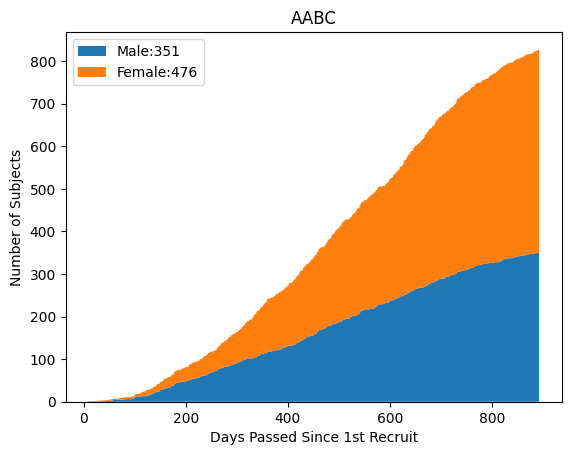

In [741]:
#PPP  


### create plot of AABC recruitment stats by SEX
# Create data
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.malesum) #[1,4,6,8,9]
y2=list(forplot.femalesum)#[2,2,7,10,12]

# Basic stacked area chart.
plt.stackplot(x,y1, y2, labels=['Male:'+str(max(y1)),'Female:'+str(max(y2))])
#plt.stackplot(x,y1, y2, labels=['Male: 346','Female: 468'])
plt.legend(loc='upper left')
plt.title("AABC")
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');



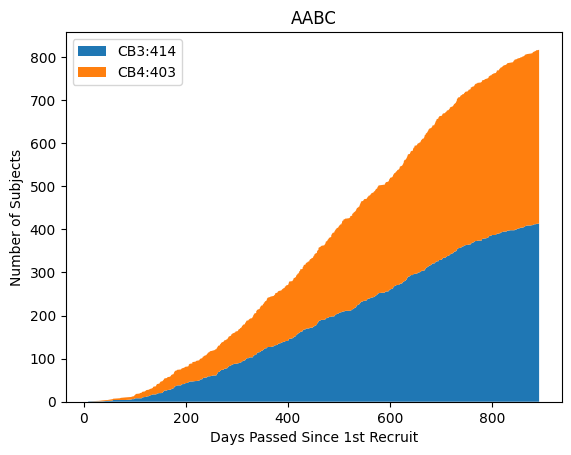

In [742]:
### create plot of AABC recruitment stats by SEX
# Create data
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.CB3sum) #[1,4,6,8,9]
y2=list(forplot.CB4sum)#[2,2,7,10,12]

# Basic stacked area chart.
plt.stackplot(x,y1, y2, labels=['CB3:'+str(max(y1)),'CB4:'+str(max(y2))])
plt.title("AABC")
plt.legend(loc='upper left')
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');

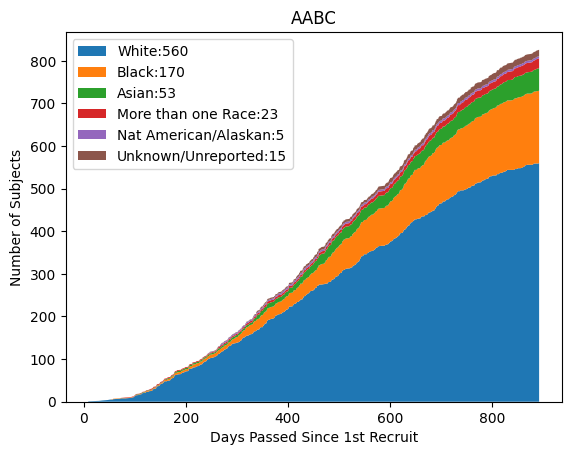

In [743]:
#BY RACE
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.whitesum) #[1,4,6,8,9]
y2=list(forplot.blacksum)#[2,2,7,10,12]
y3=list(forplot.asiansum)
y4=list(forplot.moret1sum)
#y5=list(forplot.natpacsum)
y6=list(forplot['natamersum'])
y7=list(forplot['nasum'])



# Basic stacked area chart.
plt.stackplot(x,y1,y2,y3,y4,y6,y7,labels=['White:'+str(max(y1)),'Black:'+str(max(y2)),'Asian:'+str(max(y3)),'More than one Race:'+str(max(y4)),'Nat American/Alaskan:'+str(max(y6)),'Unknown/Unreported:'+str(max(y7))])
#plt.stackplot(x,y1,y2,y3,y4,y6,y7,labels=['White: 550','Black: 171','Asian: 50','More than one Race: 22','Nat American/Alaskan: 5','Unknown/Unreported: 15'])

plt.legend(loc='upper left')
plt.title("AABC")
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');

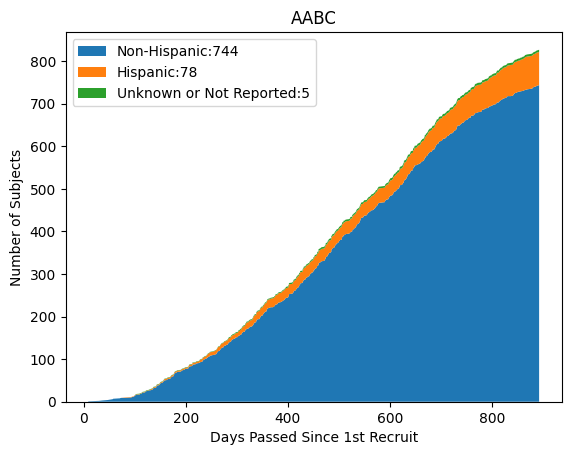

In [744]:
#BY ETHNICITY
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.nonhispanicsum) #[1,4,6,8,9]
y2=list(forplot.hispanicsum)#[2,2,7,10,12]
y3=list(forplot.unkhispsum)
# Basic stacked area chart.
plt.stackplot(x,y1, y2,y3, labels=['Non-Hispanic:'+str(max(y1)),'Hispanic:'+str(max(y2)),'Unknown or Not Reported:'+str(max(y3))])
#plt.stackplot(x,y1, y2,y3, labels=['Non-Hispanic: 734','Hispanic: 75','Unknown or Not Reported: 5'])
plt.legend(loc='upper left')
plt.title("AABC")
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');

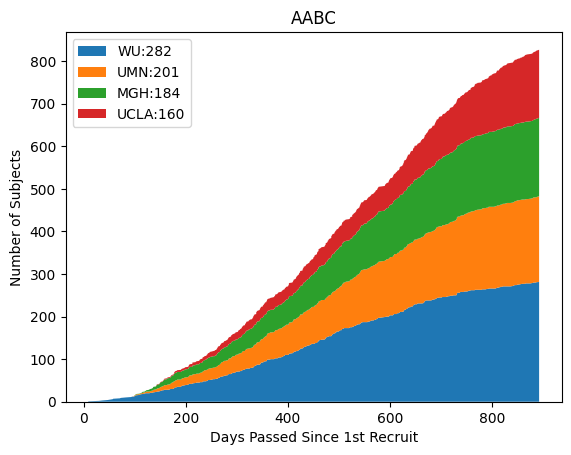

In [745]:
#By Site
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.wusum) #[1,4,6,8,9]
y2=list(forplot.umnsum)#[2,2,7,10,12]
y3=list(forplot.mghsum)
y4=list(forplot.uclasum)
# Basic stacked area chart.
plt.stackplot(x,y1, y2,y3, y4,labels=['WU:'+str(max(y1)),'UMN:'+str(max(y2)),'MGH:'+str(max(y3)),'UCLA:'+str(max(y4))])
#plt.stackplot(x,y1, y2,y3, y4,labels=['WU: 282','UMN: 198','MGH: 180','UCLA: 154'])
plt.legend(loc='upper left')
plt.title("AABC")
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');


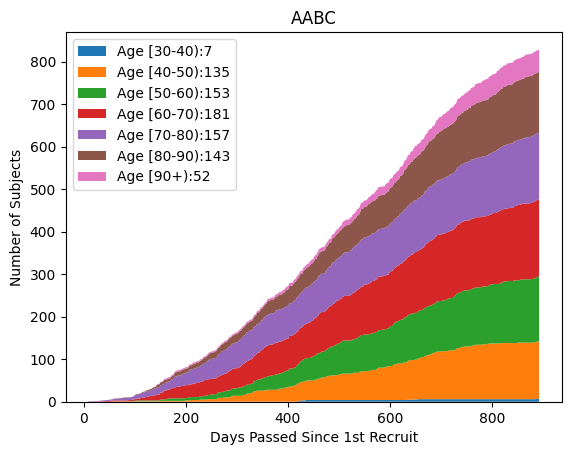

In [746]:
#By Age Bin
x=list(forplot.dayspassed) #range(1,6)
y2=list(forplot.age30sum)#[2,2,7,10,12]
y3=list(forplot.age40sum)
y4=list(forplot.age50sum)
y5=list(forplot.age60sum)
y6=list(forplot.age70sum)
y7=list(forplot.age80sum)
y8=list(forplot.age90sum)

# Basic stacked area chart.
plt.stackplot(x,y2,y3,y4,y5,y6,y7,y8, labels=['Age [30-40):'+str(max(y2)),'Age [40-50):'+str(max(y3)),'Age [50-60):'+str(max(y4)),'Age [60-70):'+str(max(y5)),'Age [70-80):'+str(max(y6)),'Age [80-90):'+str(max(y7)),'Age [90+):'+str(max(y8))])
plt.legend(loc='upper left')
plt.title("AABC")
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');

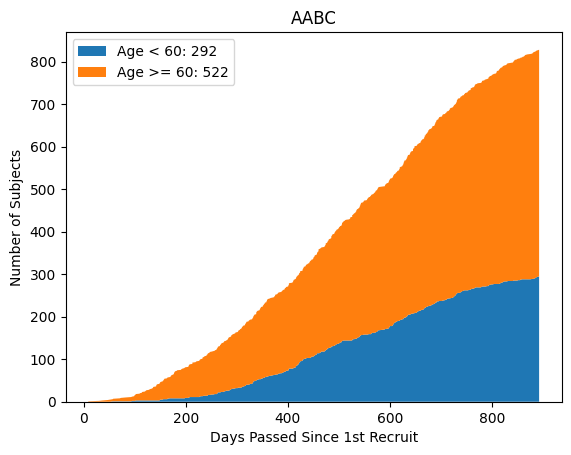

In [747]:
#By Age Bin
x=list(forplot.dayspassed) #range(1,6)
y2=list(forplot.age1sum60)#[2,2,7,10,12]
y3=list(forplot.age2sum60)


# Basic stacked area chart.
plt.stackplot(x,y2,y3, labels=['Age < 60: 292', 'Age >= 60: 522'])
plt.legend(loc='upper left')
plt.title("AABC")
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');

### AABC Crosstabulations
### NEED TO BE FIXED TO REMOVE DUPLICATES

Site,MGH,UCLA,UMN,WashU
Race,,,,
Asian,12,26,13,2
Black,27,19,19,105
More than one,4,15,2,2
Nat Amer/Alaskan,0,1,1,3
Nat Hawaiian/PI,0,1,0,0
Unknown,5,5,5,0
White,136,93,161,170


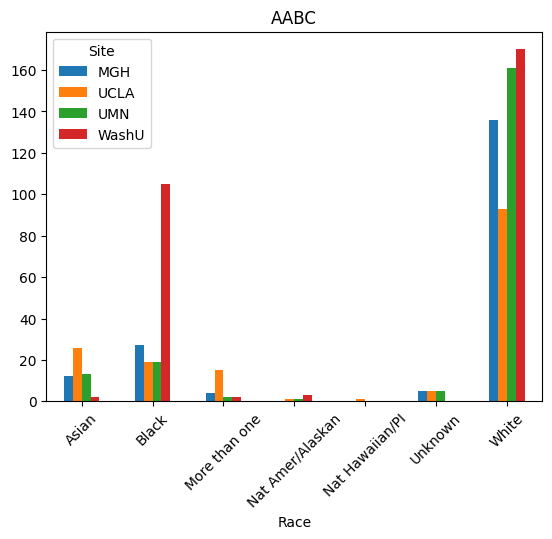

In [748]:
#Crosstabs x Site

pd.crosstab(forplot.Race,forplot.Site).plot.bar(rot=45,title='AABC')
#pd.crosstab(forplot.Race,forplot.Site).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Race,forplot.Site)

Site,MGH,UCLA,UMN,WashU
Ethnicity,,,,
Hispanic,17,48,9,4
Non-Hispanic,165,111,190,278
Unknown,2,1,2,0


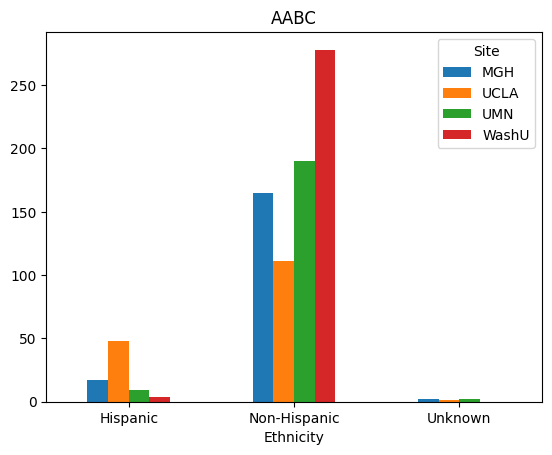

In [749]:
pd.crosstab(forplot.Ethnicity,forplot.Site).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.Ethnicity,forplot.Site).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Ethnicity,forplot.Site)

Site,MGH,UCLA,UMN,WashU
AgeGroup,,,,
"[30, 40)",0,0,0,7
"[40, 50)",24,27,36,48
"[50, 60)",35,36,33,49
"[60, 70)",41,34,38,67
"[70, 80)",30,23,40,64
"[80, 90)",36,29,41,37
"[90, 125)",18,11,13,10


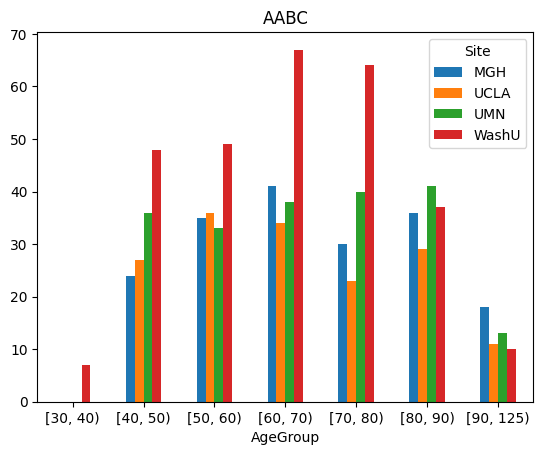

In [750]:
pd.crosstab(forplot.AgeGroup,forplot.Site).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.AgeGroup,forplot.Site).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.AgeGroup,forplot.Site)

Site,MGH,UCLA,UMN,WashU
Sex,,,,
Female,104,89,113,170
Male,80,71,88,112


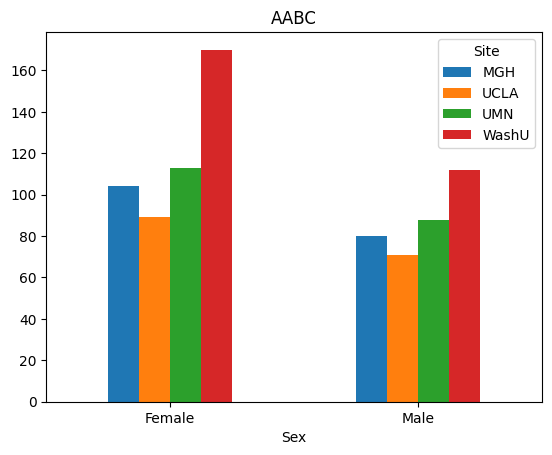

In [751]:
pd.crosstab(forplot.Sex,forplot.Site).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.Sex,forplot.Site).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Sex,forplot.Site)

Race,Asian,Black,More than one,Nat Amer/Alaskan,Nat Hawaiian/PI,Unknown,White
AgeGroup,,,,,,,
"[30, 40)",0,5,0,0,0,0,2
"[40, 50)",13,32,6,1,0,5,78
"[50, 60)",13,40,6,3,1,4,86
"[60, 70)",15,44,7,1,0,6,107
"[70, 80)",7,33,2,0,0,0,115
"[80, 90)",5,14,1,0,0,0,123
"[90, 125)",0,2,1,0,0,0,49


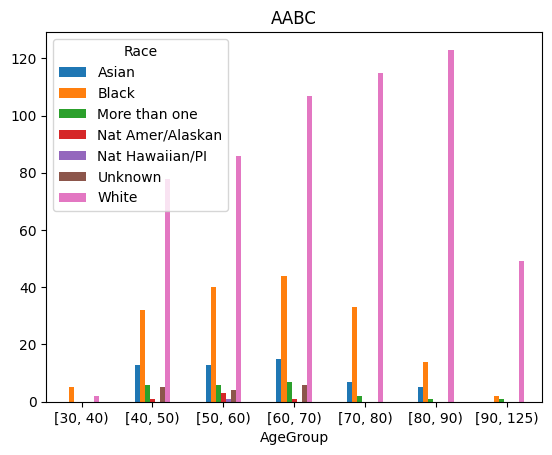

In [752]:
pd.crosstab(forplot.AgeGroup,forplot.Race).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.AgeGroup,forplot.Race).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.AgeGroup,forplot.Race)

Ethnicity,Hispanic,Non-Hispanic,Unknown
AgeGroup,,,
"[30, 40)",0,7,0
"[40, 50)",22,112,1
"[50, 60)",23,128,2
"[60, 70)",17,162,1
"[70, 80)",7,150,0
"[80, 90)",6,136,1
"[90, 125)",3,49,0


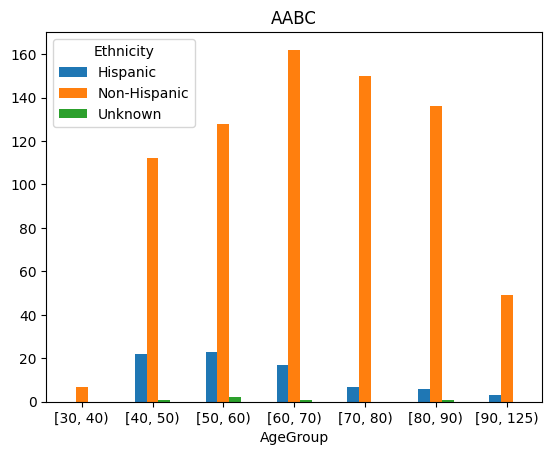

In [753]:
pd.crosstab(forplot.AgeGroup,forplot.Ethnicity).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.AgeGroup,forplot.Ethnicity).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.AgeGroup,forplot.Ethnicity)


Sex,Female,Male
AgeGroup,,
"[30, 40)",4,3
"[40, 50)",81,54
"[50, 60)",93,60
"[60, 70)",114,66
"[70, 80)",82,75
"[80, 90)",74,69
"[90, 125)",28,24


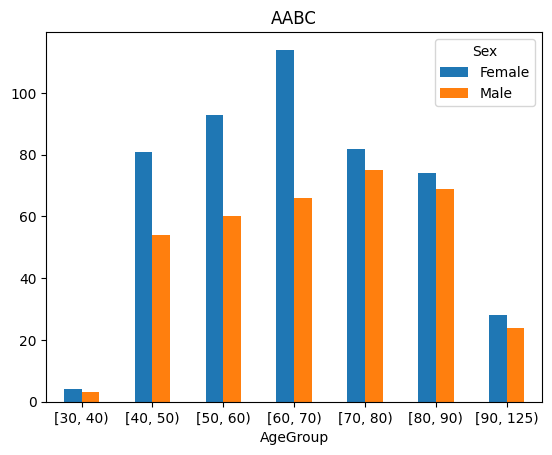

In [754]:
pd.crosstab(forplot.AgeGroup,forplot.Sex).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.AgeGroup,forplot.Sex).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.AgeGroup,forplot.Sex)

Sex,Female,Male
Race,,
Asian,26,27
Black,117,53
More than one,12,11
Nat Amer/Alaskan,2,3
Nat Hawaiian/PI,0,1
Unknown,9,6
White,310,250


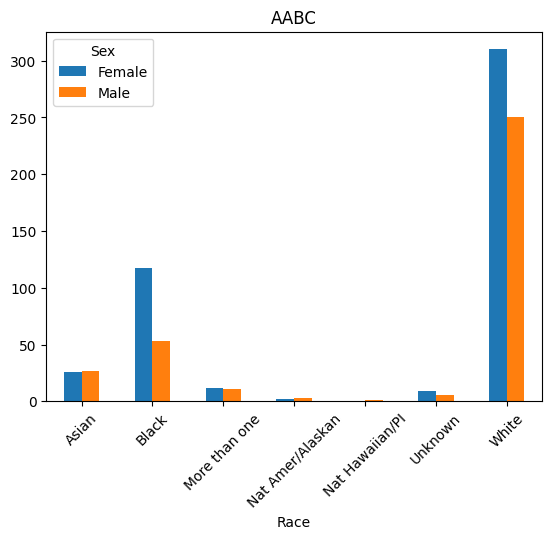

In [755]:
#Crosstabs
pd.crosstab(forplot.Race,forplot.Sex).plot.bar(rot=45,title='AABC')
#pd.crosstab(forplot.Race,forplot.Sex).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Race,forplot.Sex)

Sex,Female,Male
Ethnicity,,
Hispanic,45,33
Non-Hispanic,428,316
Unknown,3,2


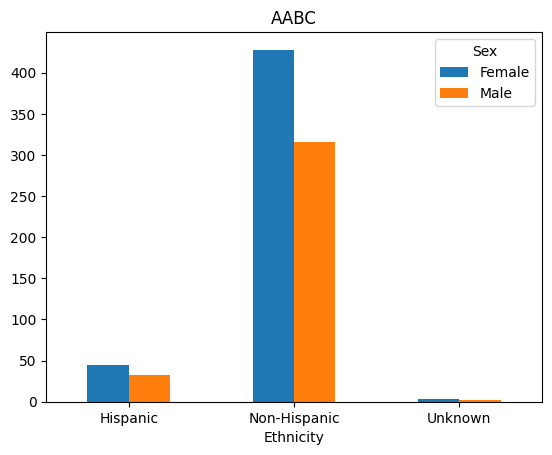

In [756]:
#Crosstabs
pd.crosstab(forplot.Ethnicity,forplot.Sex).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.Ethnicity,forplot.Sex).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Ethnicity,forplot.Sex)

Sex,Female,Male
Counterbalance,,
,5,5
CB3,242,172
CB4,229,174


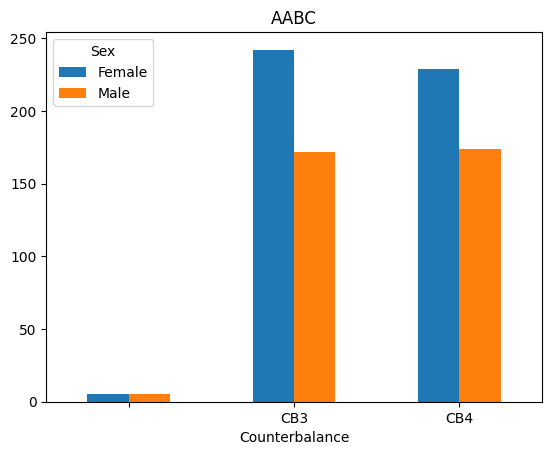

In [757]:
#Crosstabs
pd.crosstab(forplot.Counterbalance,forplot.Sex).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.Counterbalance,forplot.Sex).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Counterbalance,forplot.Sex)

Counterbalance,,CB3,CB4
Race,,,
Asian,1,24,28
Black,1,84,85
More than one,0,15,8
Nat Amer/Alaskan,0,3,2
Nat Hawaiian/PI,0,1,0
Unknown,1,8,6
White,7,279,274


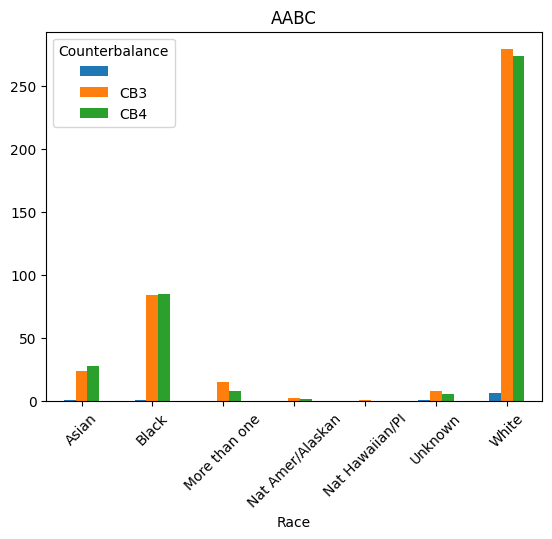

In [758]:
#Crosstabs
pd.crosstab(forplot.Race,forplot.Counterbalance).plot.bar(rot=45,title='AABC')
#pd.crosstab(forplot.Race,forplot.Counterbalance).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Race,forplot.Counterbalance)

Counterbalance,,CB3,CB4
AgeGroup,,,
"[30, 40)",0,4,3
"[40, 50)",3,70,62
"[50, 60)",1,83,69
"[60, 70)",1,82,97
"[70, 80)",1,80,76
"[80, 90)",4,69,70
"[90, 125)",0,26,26


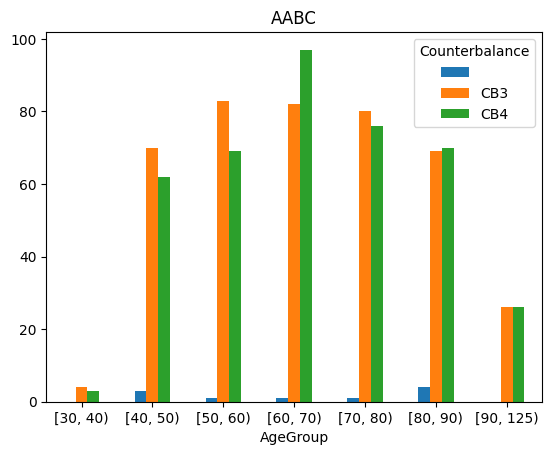

In [759]:
#Crosstabs
pd.crosstab(forplot.AgeGroup,forplot.Counterbalance).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.AgeGroup,forplot.Counterbalance).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.AgeGroup,forplot.Counterbalance)

### New crosstabs plots including income and education group

Race,Asian,Black,More than one,Nat Amer/Alaskan,Nat Hawaiian/PI,Unknown,White
IncomeGroup,,,,,,,
0-20k,2,16,0,0,0,2,14
20k-50k,3,50,5,1,0,1,92
50k-100k,13,70,12,1,1,8,196
100k+,31,21,5,2,0,3,208
Don't know,4,13,1,1,0,1,50


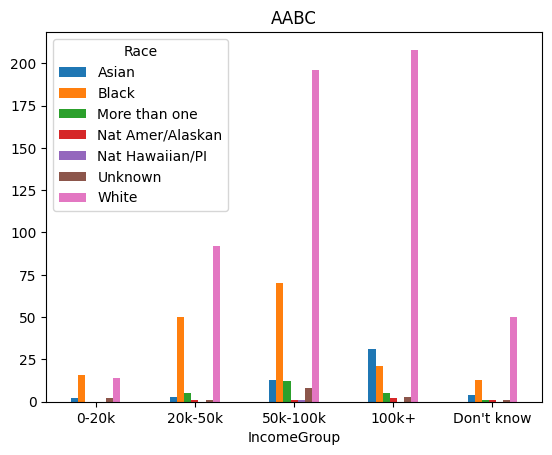

In [760]:
#Crosstabs
pd.crosstab(forplot.IncomeGroup,forplot.Race).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.AgeGroup,forplot.Counterbalance).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.IncomeGroup,forplot.Race)

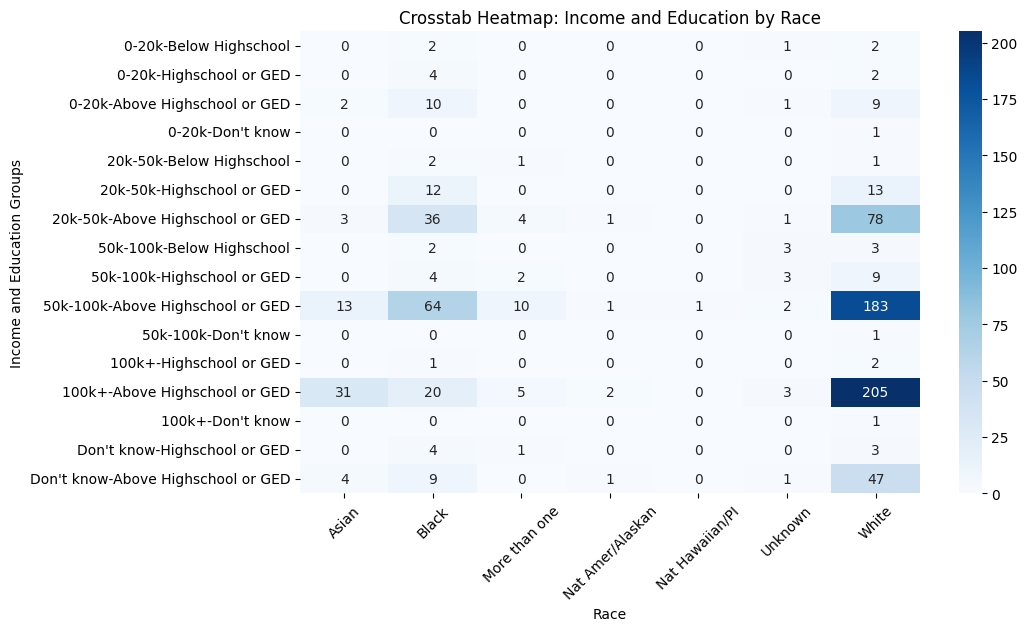

In [761]:
crosstab_result = pd.crosstab([forplot['Race']], [forplot['IncomeGroup'], forplot['EduGroup']], margins=True)
crosstab_reset = crosstab_result.reset_index()

# Using a heatmap to visualize
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab_result.iloc[:-1, :-1].T, annot=True, cmap='Blues', fmt='g')

# Customize plot
plt.xticks(rotation=45)
plt.title('Crosstab Heatmap: Income and Education by Race')
plt.ylabel('Income and Education Groups')
plt.xlabel('Race')

plt.show()